In [4]:
#### 노트북 셀 가로 넓게 보기
from IPython.core.display import display, HTML

notebook_config = ""
notebook_config += "<style>"
notebook_config += "  .container { width:90% !important; }"
notebook_config += "</style>"
HTML(notebook_config)

# Install Modules

In [5]:
# f1 평가 메트릭을 위한 tensorflow 모듈
!pip install tensorflow_addons

# 한글 자모 구분을 알아내는 모듈
!pip install jamo

     |████████████████████████████████| 679 kB 5.3 MB/s 


# Set Common Config

In [6]:
# 만들어진 Copus 사용 여부 (신속한 재현성 검토시 True로 설정)
# False 설정시 Copus를 재생성합니다.
USE_MADE_CORPUS = True

# 훈련된 Model 사용 여부 (재현성 검토시 True로 설정)
# TPU를 사용할 수 없는 경우 프로그램은 종료됩니다.
# False 설정시 TPU를 사용하여 Model을 새로 생성합니다
# TPU를 사용하여 Model을 새로 생성하는 경우 TPU특성상 실행할 때 마다 새로운 Model이 생성됩니다.
USE_MADE_MODEL = True


In [7]:
# 실행환경이 COLAB인 경우 True 설정
IS_COLAB = True

# 프로그램 SEED 설정 : 각종 SEED를 사용하는 모듈에 적용됩니다.
SEED = 42

# 프로그램 버전 설정 : 제출용 파일 생성 및 학습된 모델을 로딩하는 경우 사용됩니다.
PROGRAM_VERSION = "999_KoELECTRA_LAST_LINUX"

# 전처리 버전 설정 : 학습 및 제출을 위한 문자열 전처리 결과를 저장하기 위해 사용됩니다.
COPUS_VERSION = "903"

In [8]:
# 일단 colab 에서 실행하는 것으로 설정
# colab에서 실행하는 경우 본인의 google drive 경로에 맞도록 설정합니다.

# Dacon에서 제공하는 train, test, sample_submission 파일이 저장되는 위치
DATA_PATH = '/content/drive/MyDrive/dacon/natural_language_based/root_dir/data/'

# 제출용 submission CSV 파일이 저장되는 위치
SUBMISSION_CSV_PATH = '/content/drive/MyDrive/dacon/natural_language_based/root_dir/submit/output/'
# 제출용 submission 확률(Numpy)파일이 저장되는 위치
SUBMISSION_NUMPY_PATH = '/content/drive/MyDrive/dacon/natural_language_based/root_dir/submit/input/'

# 전처리된 copus가 저장되는 위치
CLEANED_PATH = '/content/drive/MyDrive/dacon/natural_language_based/root_dir/cleaned/'

# 훈련된 모델이 저장되는 위치
MODEL_PATH = '/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/'

# 사전학습모델이 캐싱되는 위치
CACHE_PATH = '/content/drive/MyDrive/dacon/natural_language_based/root_dir/cache/'

In [9]:
# 이럴일은 없겠지만...
# colab이 아니면...로컬에서 실행하는 경우라든지...
# 본인의 디렉토리 환경에 맞도록 수정하세요.
if not IS_COLAB:
    DATA_PATH = './data/'
    SUBMISSION_CSV_PATH = './sub/'
    SUBMISSION_NUMPY_PATH = './sub/'
    CLEANED_PATH = './cleaned/'
    MODEL_PATH = './models/'
    CACHE_PATH = './cache/'

In [10]:
# colab에서 실행하는 경우 google drive에 연결 및 colab 서버에 drive mount
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Basic Modules

In [11]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import platform
from tqdm import tqdm
tqdm.pandas()
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
import collections
import json
import gc

import warnings; warnings.filterwarnings("ignore")
from scipy.stats import gmean

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import tensorflow_addons as tfa

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

print('tensorflow version ' , tf.__version__)
print('keras version ', keras.__version__)
print('tfa(tensorflow addon) version ', tfa.__version__)

tensorflow version  2.6.0
keras version  2.6.0
tfa(tensorflow addon) version  0.13.0


# Define functions

In [12]:
# 재현성 구성함수
def reset_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.compat.v1.set_random_seed(seed)
    tf.random.set_seed(seed)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET {}".format(seed))  # optional

reset_seeds(SEED)

RANDOM SEEDS RESET 42


In [13]:
# stopword 처리 함수: 간단하게 하늘 외자만 삭제
stop_words = 'ㄱ,ㄴ,ㄷ,ㄹ,ㅁ,ㅂ,ㅅ,ㅇ,ㅈ,ㅊ,ㅋ,ㅌ,ㅍ,ㅎ,ㅏ,ㅑ,ㅓ,ㅕ,ㅗ,ㅛ,ㅜ,ㅣ,ㅡ,ㅔ,ㅐ'
def common_stopword(x):
    for token in stop_words.split(','):
        x = x.replace(token, ' ')
        x = x.strip()
    return x

# mecab 패키지를 이용한 형태소 분석함수 - 한글, 영문자만 선택하여 단어(문장) 재구성
def extract_nv2_mecab(x):
    x = x.lower()
    x = x.replace('&amp;', ' ')
    x = re.sub("[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ&]", " ", x)
    result = mecab.pos(x)
    text = []
    for token, pos in result:
        if pos.startswith('N') or pos.startswith('V') or pos.startswith('SL'):  # 명사, 동사, 외국어
            text.append(f"{token}")
    text = " ".join(text)
    text = common_stopword(text)
    return text

# 문장에서 한 글자로 구성된 단어는 제외하고 문장을 재구성하여 리턴
def extract_except_one_length(x):
    new_sentence = []
    tokens = x.split()
    for word in tokens:
        if len(word) > 1:
            new_sentence.append(word)
    return ' '.join(new_sentence)

In [14]:
# Aug 함수 : 요약정보 3개 컬럼을 이용하여 일정 길이만큼으로 데이타를 분리한 후 훈련용 데이타를 추가 생성하는 함수
def get_text_augmentation(word_count, col_name, y_label, text, trunc=True):
    '''
    word_count : 분리할 길이
    col_name : 증강된 데이타를 저장하는 컬럼명
    y_label : 증강된 데이타의 label 값
    text : 증강할 대상 데이타
    trunc : 증강과정에서 마지막 증강 데이타가 분리할 길이(word_count) 보다 작은 경우 버릴 것인지 여부
    '''    
    max_word_count = word_count
    l_total = []
    l_parcial = []
    if len(text.split())//max_word_count > 0:
        n = len(text.split())//max_word_count
    else:
        n = 1
    if (len(text.split()) % max_word_count > 0) and (trunc == False):
        n += 1

    for w in range(n):
        l_parcial = text.split()[w*max_word_count:w*max_word_count + max_word_count]
        l_total.append(" ".join(l_parcial))

    ret_df = pd.DataFrame(l_total, columns=[col_name])
    ret_df['label'] = y_label

    return ret_df

# t = get_text_augmentation(87, 'text1_cleaned', train_data.iloc[0]['label'], train_data.iloc[0]['text_all_cleaned'])
# t

In [15]:
# 인수(idx)로 받은 모델번호의 모델파일명을 불러오는 함수
def get_model_filename(idx):
    model_list_path = f'{MODEL_PATH}{PROGRAM_VERSION}'
    file_list = os.listdir(model_list_path)
    file_list = [file_name for file_name in file_list if PROGRAM_VERSION in file_name]
    model_filename = [file_name for file_name in file_list if 'WEIGHTS_' + str(idx) in file_name]
    if len(model_filename) == 0:
        return 'not found'
    return model_filename[0]
# get_model_filename(0)

In [16]:
# 디렉토리 생성 함수 (없는 경우만 신규로 생성)
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
 
# createFolder(f'{MODEL_PATH}{PROGRAM_VERSION}')

In [17]:
# 정의된 디렉토리가 없는 경우 새로 생성
createFolder(f'{CACHE_PATH}')
createFolder(f'{MODEL_PATH}')
createFolder(f'{MODEL_PATH}{PROGRAM_VERSION}')
createFolder(f'{CLEANED_PATH}')
createFolder(f'{SUBMISSION_CSV_PATH}')
createFolder(f'{SUBMISSION_NUMPY_PATH}')

In [18]:
# 디렉토리 데이타 확인
!ls {CLEANED_PATH}

climate_dict.txt		  train_mecab_kor_eng_903_LINUX.csv
test_mecab_kor_eng_903_LINUX.csv  train_pre.csv
test_pre.csv			  web_기후기술분류체계.txt


In [19]:
# 디렉토리 데이타 확인
!ls {DATA_PATH}

labels_mapping.csv  sample_submission.csv  test.csv  train.csv


# [Linux버전] Mecab 설치 및 사용자 단어 추가

In [20]:
# Mecab 설치
# 출처> https://somjang.tistory.com/entry/Google-Colab%EC%97%90%EC%84%9C-Mecab-koMecab-ko-dic-%EC%89%BD%EA%B2%8C-%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0?category=348828
# 출처> https://dacon.io/codeshare/2884?page=1&dtype=recent

In [21]:
%%time

# Mecab 설치
if not USE_MADE_CORPUS:
    !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
    !bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.2 µs


In [22]:
# 중분류, 소분류가 잘못 만들어지는 것을 확인하고, 사용자 단어 사전에 추가하여 정상적인 형태소분리가 되도록 한다.
# 사용자 단어 추가 방법
# 출처> https://somjang.tistory.com/entry/Google-Colab에서-mecab-ko-dic-사용자-사전-추가하기
if not USE_MADE_CORPUS:
    from konlpy.tag import Mecab 
    mecab = Mecab() 
    print(mecab.pos("대분류를 구분하고 중분류를 구분하고 소분류로 나눈다"))

In [23]:
# [('대분류', 'NNG'), ('를', 'JKO'), ('구분', 'NNG'), ('하', 'XSV'), ('고', 'EC'), ('중분', 'NNG'), ('류', 'XSN'), ('를', 'JKO'), ('구분', 'NNG'), ('하', 'XSV'), ('고', 'EC'), ('소분', 'NNG'), ('류', 'XSN'), ('로', 'JKB'), ('나눈다', 'VV+EC')]

In [24]:
# 사용자 단어 사전 디렉토리 확인
if not USE_MADE_CORPUS:
    !ls /content/mecab-ko-dic-2.1.1-20180720/user-dic

In [25]:
# PDF파일에서 발췌한 대회전용 단어사전 정보 읽기
if not USE_MADE_CORPUS:
    word_list = pd.read_csv(f'{CLEANED_PATH}climate_dict.txt', sep='\t', names=['word', 'category'])
    display(word_list.head(5))

In [26]:
# Mecab형식의 단어사전 읽기
if not USE_MADE_CORPUS:
    with open("/content/mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv", 'r', encoding='utf-8') as f:
        file_data = f.readlines()
    display(file_data)

In [27]:
# Mecab 형식의 단어사전에 추가할 F, T 값은 마지막 단어에 받침이 없으면 False의 F, 있으면 True의 T
# 이것을 알아내는 모듈 jamo를 이용
from jamo import h2j, j2hcj 
def get_jongsung_TF(sample_text): 
    sample_text_list = list(sample_text) 
    last_word = sample_text_list[-1] 
    last_word_jamo_list = list(j2hcj(h2j(last_word))) 
    last_jamo = last_word_jamo_list[-1] 
    jongsung_TF = "T" 
    if last_jamo in ['ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ', 'ㅘ', 'ㅚ', 'ㅙ', 'ㅝ', 'ㅞ', 'ㅢ', 'ㅐ,ㅔ', 'ㅟ', 'ㅖ', 'ㅒ']: 
        jongsung_TF = "F" 
    return jongsung_TF

In [28]:
# nnp.csv 단어 사전에 추가
if not USE_MADE_CORPUS:
    with open("/content/mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv", 'r', encoding='utf-8') as f:
        file_data = f.readlines() 
        for word in word_list.word: 
            jongsung_TF = get_jongsung_TF(word) 
            line = '{},,,,NNP,*,{},{},*,*,*,*,*\n'.format(word, jongsung_TF, word) 
            file_data.append(line)

    with open("/content/mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv", 'w', encoding='utf-8') as f: 
        for line in file_data: 
            f.write(line)

In [29]:
# Mecab형식의 단어사전 다시 읽기
if not USE_MADE_CORPUS:
    with open("/content/mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv", 'r', encoding='utf-8') as f:
        file_data = f.readlines()
    display(file_data)

In [30]:
# 단어사전 생성
if not USE_MADE_CORPUS:
    !bash /content/mecab-ko-dic-2.1.1-20180720/tools/add-userdic.sh

In [31]:
%%time
if not USE_MADE_CORPUS:
    # 단어 사전 우선 순위 조정
    with open("/content/mecab-ko-dic-2.1.1-20180720/user-nnp.csv", 'r', encoding='utf-8') as f:
        file_data = f.readlines()

    higher_words = []
    for word in file_data:
        word = word.replace('2953', '0')
        higher_words.append(word)

    with open("/content/mecab-ko-dic-2.1.1-20180720/user-nnp.csv", 'w', encoding='utf-8') as f: 
        for line in higher_words: 
            f.write(line)

    !cd /content/mecab-ko-dic-2.1.1-20180720; make clean; make install

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.4 µs


In [32]:
# 단어 사전에 추가되고 우선순위가 조정되었는 확인
if not USE_MADE_CORPUS:
    mecab = Mecab() 
    print(mecab.pos("대분류를 구분하고 중분류를 구분하고 소분류로 나눈다"))

In [33]:
# [('대분류', 'NNP'), ('를', 'JKO'), ('구분', 'NNG'), ('하', 'XSV'), ('고', 'EC'), ('중분류', 'NNP'), ('를', 'JKO'), ('구분', 'NNG'), ('하', 'XSV'), ('고', 'EC'), ('소분류', 'NNP'), ('로', 'JKB'), ('나눈다', 'VV+EC')]

# [윈도우 버전] Mecab 설치 및 사용자 단어 추가 (참고자료)

In [34]:
# Mecab 설치
# <출처> https://cleancode-ws.tistory.com/97

In [35]:
# 사용자 단어 사전 추가
# <출처> https://joyhong.tistory.com/m/136
# <출처> https://joyhong.tistory.com/128?category=915140

# 훈련대상 데이타 전처리

- Read Original Data

In [36]:
if not USE_MADE_CORPUS:
    train = pd.read_csv(f'{DATA_PATH}train.csv')
    test = pd.read_csv(f'{DATA_PATH}test.csv')
    display(train.shape, test.shape)

- Ready Mecab Instance 

In [37]:
# mecab 준비
if not USE_MADE_CORPUS:
    if platform.system().lower() == 'linux':
        mecab = Mecab('/content/mecab-ko-dic-2.1.1-20180720')
    else:
        mecab = Mecab('c:/mecab/mecab-ko-dic')
    display(mecab)

- 전처리 데이타 준비

In [38]:
# 전처리 대상 데이타는 제공된 데이타 중에 사업명, 사업_부처명, 내역사업명, 과제명, 요약문_한글키워드, 요약문_영문키워드 만 사용합니다.

if not USE_MADE_CORPUS:
    # train
    train["text1"] = train["사업명"] + " " + train["사업_부처명"] + " " + train["내역사업명"] + " " + train["과제명"] + " " + train["요약문_한글키워드"].fillna('UNKNOWN 모름') + " " + train["요약문_영문키워드"].fillna('UNKNOWN 모름')

    # test
    test["text1"] = test["사업명"] + " " + test["사업_부처명"] + " " + test["내역사업명"] + " " + test["과제명"] + " " + test["요약문_한글키워드"].fillna('UNKNOWN 모름') + " " + test["요약문_영문키워드"].fillna('UNKNOWN 모름')


- 전처리 및 결과 저장

In [39]:
%%time
if not USE_MADE_CORPUS:
    # 형태소 분석 후 필요 형태소만 추출
    train["text1_semi_cleaned"] = train["text1"].progress_apply(extract_nv2_mecab)
    test["text1_semi_cleaned"] = test["text1"].progress_apply(extract_nv2_mecab)

    # 한글자로 구성된 단어를 제외한 문장 재구성
    train["text1_cleaned"] =  train["text1_semi_cleaned"].progress_apply(extract_except_one_length)
    test["text1_cleaned"] =  test["text1_semi_cleaned"].progress_apply(extract_except_one_length)

    # 저장에 필요한 컬럼만 선택
    train_result = train[['index', 'text1_cleaned', 'label']]
    test_result = test[['index', 'text1_cleaned']]

    # 전처리 결과 저장
    train_result.to_csv(f'{CLEANED_PATH}train_mecab_kor_eng_{COPUS_VERSION}_LINUX.csv', index=False)
    test_result.to_csv(f'{CLEANED_PATH}test_mecab_kor_eng_{COPUS_VERSION}_LINUX.csv', index=False)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.4 µs


# Read Cleaned Data

In [40]:
train_data = pd.read_csv(f'{CLEANED_PATH}train_mecab_kor_eng_{COPUS_VERSION}_LINUX.csv')
test_data = pd.read_csv(f'{CLEANED_PATH}test_mecab_kor_eng_{COPUS_VERSION}_LINUX.csv')
submission = pd.read_csv(f'{DATA_PATH}sample_submission.csv')

In [41]:
train_data.shape, test_data.shape

((174304, 3), (43576, 2))

In [42]:
train_data.isnull().sum()

index            0
text1_cleaned    0
label            0
dtype: int64

In [43]:
train_data.head()

,index,text1_cleaned,label
0,0,농업 기초 기반 연구 농촌 흥청 농산물 안전성 연구 유전 정보 활용 새로운 해충 분...,24
1,1,공학 학술 연구 기반 구축 r&d 교육부 지역 대학 우수 과학자 지원 사업 대장암 ...,0
2,2,중소기업 기술 혁신 개발 중소기업청 혁신 기업 기술 개발 목질 셀룰로오스 식물 자원...,0
3,3,창업 성장 기술 개발 r&d 중소벤처기업부 창업 사업화 연계 과제 소화기 진단 분자...,0
4,4,공학 개인 기초연구 지원 교육부 기본 연구 지원 위암 환자 항암제 반응 예측 위한 ...,0


In [44]:
test_data.isnull().sum()

index            0
text1_cleaned    0
dtype: int64

In [45]:
test_data.head()

,index,text1_cleaned
0,174304,경제 협력 산업 육성 산업통상자원부 자동차 융합 부품 fssw 기술 적용 경량 차체...
1,174305,개인 기초연구 과기정통부 r&d 과학기술정보통신부 신진 연구 연구비 이상 입자 묘사...
2,174306,개인 기초연구 미래 과학기술정보통신부 자유 공모 출생체중 가족 위한 지역 사회 중심...
3,174307,산학연 협력 기술 개발 r&d 중소벤처기업부 전략 협력 지역 유망 폴리 cnc 정밀...
4,174308,공학 학술 연구 기반 구축 r&d 교육부 지역 대학 우수 과학자 지원 사업 다결정 ...


<h2>작업용 컬럼으로 복사</h2>

In [46]:
train_data['text_cleaned_ok'] = train_data['text1_cleaned']
test_data['text_cleaned_ok'] = test_data['text1_cleaned']


# 사전학습모델(KoELECTRA) 준비

In [47]:
!pip install sentencepiece
!pip install transformers==4.1.1
!pip install tensorflow_text
from transformers import TFBertModel
from transformers import TFElectraModel, ElectraTokenizer
# import tensorflow_text as tftext


     |████████████████████████████████| 1.2 MB 5.3 MB/s 
     |████████████████████████████████| 1.5 MB 5.5 MB/s 
     |████████████████████████████████| 895 kB 44.5 MB/s 
     |████████████████████████████████| 2.9 MB 22.1 MB/s 
     |████████████████████████████████| 4.3 MB 5.4 MB/s 
     |████████████████████████████████| 454.4 MB 7.5 kB/s 
     |████████████████████████████████| 462 kB 63.5 MB/s 
     |████████████████████████████████| 1.2 MB 42.9 MB/s 
     |████████████████████████████████| 4.0 MB 43.1 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.39.0
    Uninstalling grpcio-1.39.0:
      Successfully uninstalled grpcio-1.39.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.

In [48]:
# TPU 객체 만들기
if 'COLAB_TPU_ADDR' in os.environ:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
    raise RuntimeError('런타임 유형변경으로 TPU를 활성화 하시기 바랍니다.')

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.98.235.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.98.235.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [49]:
# KoElectra Tokenizer 모듈 불러오기
tokenizer = ElectraTokenizer.from_pretrained("kykim/electra-kor-base", cache_dir=CACHE_PATH) # monologg/koelectra-base-v3-discriminator, kykim/electra-kor-base
token = tokenizer.tokenize("농업 기초 기반 연구 농촌 흥청 농산물 안전성")
token

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

['농업', '기초', '기반', '연구', '농촌', '흥', '##청', '농산물', '안전성']

- 최적화된 훈련용 정보 설정

In [50]:
# 단어 최대 길이 : 최대 길이 문장의 약 70% 
SEQ_LEN = 87
# 분석 문장을 포함하고 있는 칼럼
DATA_COLUMN = "text_cleaned_ok"
# 분석결과 label을 포함하고 있는 칼럼
LABEL_COLUMN = "label"

In [51]:
# 전처리 데이타 준비에서 사용한 불용어 삭제 처리
def clean_text(text):
    text = text.replace('unknown', '')
    text = text.replace('모름', '')
    text = text.replace('  ', '')
    return text
train_data[DATA_COLUMN] = train_data[DATA_COLUMN].progress_apply(clean_text)
test_data[DATA_COLUMN] = test_data[DATA_COLUMN].progress_apply(clean_text)

100%|██████████| 43576/43576 [00:00<00:00, 346068.04it/s]


- 간단한 데이타 탐색

In [52]:
# 띄어쓰기를 기준으로 최대 길이 확인
np.max([len(str(x).split()) for x in train_data[DATA_COLUMN]]), np.max([len(str(x).split()) for x in test_data[DATA_COLUMN]]), np.min([len(str(x).split()) for x in test_data[DATA_COLUMN]])

(126, 112, 7)

In [53]:
# 띄어쓰기를 기준으로 평균 길이 확인
np.mean([len(str(x).split()) for x in train_data[DATA_COLUMN]]), np.mean([len(str(x).split()) for x in test_data[DATA_COLUMN]])

(39.313951487057096, 39.33305030291904)

In [54]:
# 띄어쓰기를 기준으로 최소 길이 문장이 무엇인지 확인
_t = np.argmin([len(str(x).split()) for x in test_data[DATA_COLUMN]])
print(_t)
[x for x in test_data[DATA_COLUMN]][_t]

36829


'한국과학기술원 연구 운영비 지원 과학기술정보통신부 education education'

(70.0, 90.0)

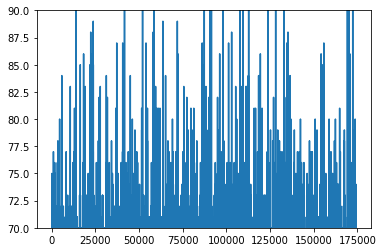

In [55]:
# 띄어쓰기를 기준으로 길이 plot 그려보기
plot_ylim = 70
train_len = [len(str(x).split()) for x in train_data[DATA_COLUMN]]
plt.plot(train_len)
plt.ylim(plot_ylim, plot_ylim + 20)

- 데이타 증강 시도

In [56]:
# # 12, 17, 20, 41 label 데이타 Augmentation
# aug_label = [42]
# temp_df = pd.DataFrame()
# print(train_data.shape)

# for i in tqdm(aug_label):
#     for idx, rows in train_data[train_data.label == i].iterrows():
#         t_ = get_text_augmentation(SEQ_LEN, 'text1_cleaned', rows['label'], str(rows['text2_cleaned']) + ' ' + str(rows['text3_cleaned']) + ' ' + str(rows['text4_cleaned']))
#         temp_df = pd.concat([temp_df, t_.reset_index()])

# train_data = pd.concat([train_data, temp_df.reset_index(drop=True)])
# print(train_data.shape)
# train_data

- KoELECTRA 사전학습 모델이 입력할 수 있는 데이타 형식으로 문장 재구성하는 함수

In [57]:
def load_data(data_df, is_train=False):
    tokens, masks, segments, targets = [], [], [], []
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype('str')
    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        token = tokenizer.tokenize(data_df.iloc[i][DATA_COLUMN])
        if len(token) > (SEQ_LEN - 2):
            token = token[:SEQ_LEN - 2]
        token = ["[CLS]"] + token + ["[SEP]"]
        pad_len = SEQ_LEN - len(token)
        token = tokenizer.convert_tokens_to_ids(token)
        token = token + [0] * pad_len
    
        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답 변수에 저장해 줌
        if is_train == True:
            data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype('int')
            targets.append(data_df.iloc[i][LABEL_COLUMN])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    if is_train == True:
        return [tokens, masks, segments], targets
    else:
        return [tokens, masks, segments]


- KoELECTRA 사전학습모델에 Fully Connection 연결하여 최종 모델을 생성하는 함수

Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
TFBaseModelOutput(last_hidden_state=<KerasTensor: shape=(None, 87, 768) dtype=float32 (created by layer 'tf_electra_model')>, hidden_states=None, attentions=None)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 87)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 87)]         0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 87)]         0                                  

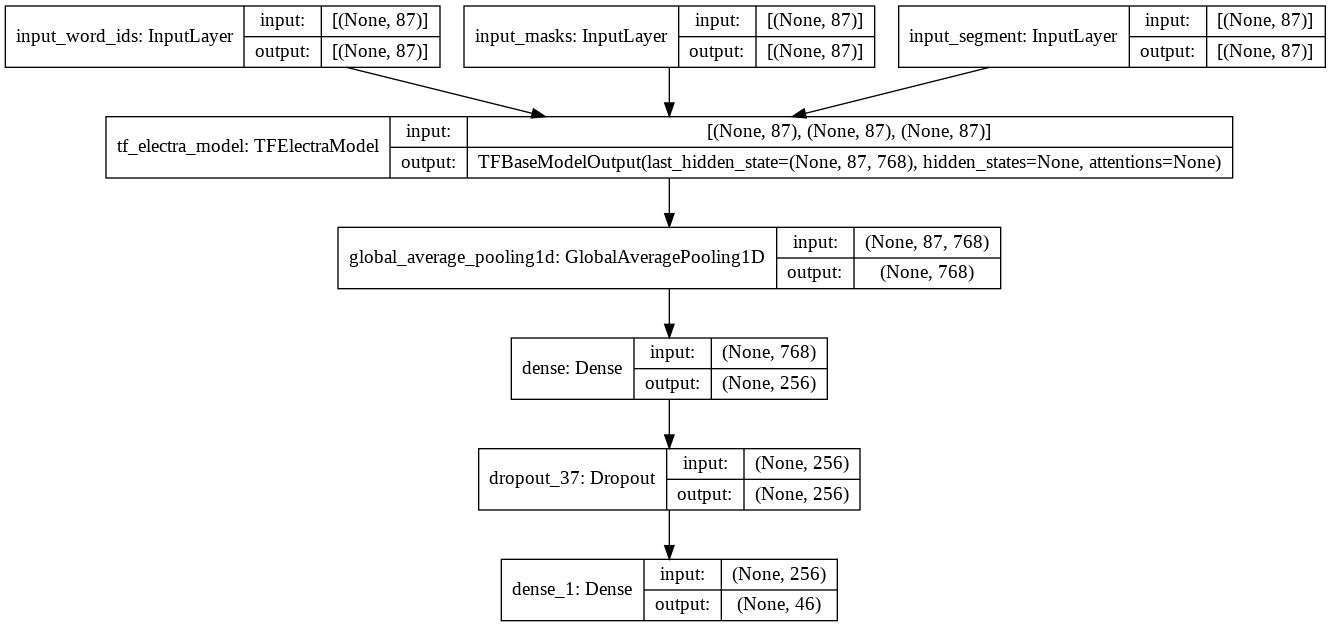

In [58]:
def build_model_koelectra():
    # 버트 pretrained 모델 로드
    electra_model = TFElectraModel.from_pretrained("kykim/electra-kor-base", from_pt=True, cache_dir=CACHE_PATH)  # monologg/koelectra-base-v3-discriminator, kykim/electra-kor-base
    # 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
    token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
    mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
    segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
    # 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
    outputs = electra_model([token_inputs, mask_inputs, segment_inputs])
    print(outputs)
    electra_outputs = outputs[0] # 사전학습모델의 output인 last_hidden_state 를 fully connection에 연결하여 분류 수행

    my_layer = tf.keras.layers.GlobalAveragePooling1D()(electra_outputs)
    my_layer = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02, seed=SEED))(my_layer)
    my_layer = tf.keras.layers.Dropout(rate=0.3)(my_layer)

    last_outputs = tf.keras.layers.Dense(46, activation='softmax', kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02, seed=SEED))(my_layer)
    last_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], last_outputs)

    # 옵티마이저는 Adam 옵티마이저 활용, 평가 메트릭에 f1 추가
    metric_f1 = tfa.metrics.F1Score(num_classes=46, average='macro')
    last_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy', metric_f1])
    return last_model

t_model = build_model_koelectra()
t_model.summary()
tf.keras.utils.plot_model(t_model, show_shapes=True, show_layer_names=True, rankdir='TB')    

In [59]:
%%time

if not USE_MADE_MODEL:
    model_list = []
    score_list = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    for i, (tri, vai) in enumerate(cv.split(train_data, train_data.label)):
        print(i, 'start....')
        x_train_ = train_data.iloc[tri]
        x_valid_ = train_data.iloc[vai]

        train_x, train_y = load_data(x_train_, True)
        valid_x, valid_y = load_data(x_valid_, True)

        reset_seeds(SEED)
        with strategy.scope():
            model = build_model_koelectra()
            early_stop = EarlyStopping(monitor='val_f1_score', patience=10, restore_best_weights=True, mode="max")
            model.fit(train_x, to_categorical(train_y), epochs=200, batch_size=64, validation_data=(valid_x, to_categorical(valid_y)), callbacks=[early_stop], verbose=1)

            # evaluate
            score = model.evaluate(valid_x, to_categorical(valid_y))
            score_list.append(score)
            model_list.append(model)

            # save model weights
            model_filename = f'{MODEL_PATH}{PROGRAM_VERSION}/{PROGRAM_VERSION}_WEIGHTS_{i}.{score[2]:.5f}.h5'
            model.save_weights(model_filename)

        del model
        del early_stop
        del train_x, train_y
        del valid_x, valid_y 
        gc.collect()

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 36.7 µs


- StratifiedKFold() 결과로 생성된 5개 모델 존재여부 확인

In [60]:
for i in range(5):
    weight_file_name = get_model_filename(i)
    print(weight_file_name)

999_KoELECTRA_LAST_LINUX_WEIGHTS_0.0.79959.h5.h5
999_KoELECTRA_LAST_LINUX_WEIGHTS_1.0.78608.h5.h5
999_KoELECTRA_LAST_LINUX_WEIGHTS_2.0.78111.h5.h5
999_KoELECTRA_LAST_LINUX_WEIGHTS_3.0.78245.h5.h5
999_KoELECTRA_LAST_LINUX_WEIGHTS_4.0.79245.h5.h5


- StratifiedKFold() 5개 모델에 대한 Validation 수행

In [61]:
%%time
model_list = []
score_list = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for i, (tri, vai) in enumerate(cv.split(train_data, train_data.label)):
    x_valid_ = train_data.iloc[vai]
    valid_x, valid_y = load_data(x_valid_, True)

    model_filename = get_model_filename(i)
    model_filename = MODEL_PATH + PROGRAM_VERSION + '/' + model_filename
    print(f'{model_filename} Weights Loading.....')

    reset_seeds(SEED)
    with strategy.scope():
        model = build_model_koelectra()
        model.load_weights(model_filename)

        # evaluate
        score = model.evaluate(valid_x, to_categorical(valid_y))
        print(f'{model_filename} Evaluate...[{score}]')
        score_list.append(score)
        model_list.append(model)

    del model
    del valid_x, valid_y 
    gc.collect()

100%|██████████| 34861/34861 [01:54<00:00, 305.08it/s]


/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/999_KoELECTRA_LAST_LINUX/999_KoELECTRA_LAST_LINUX_WEIGHTS_0.0.79959.h5.h5 Weights Loading.....
RANDOM SEEDS RESET 42


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

TFBaseModelOutput(last_hidden_state=<KerasTensor: shape=(None, 87, 768) dtype=float32 (created by layer 'tf_electra_model_1')>, hidden_states=None, attentions=None)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 46) dtype=float32>]
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=

1090/1090 [==============================] - 46s 27ms/step - loss: 0.2700 - accuracy: 0.9537 - f1_score: 0.7996
/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/999_KoELECTRA_LAST_LINUX/999_KoELECTRA_LAST_LINUX_WEIGHTS_0.0.79959.h5.h5 Evaluate...[[0.27000007033348083, 0.9537017941474915, 0.7995865345001221]]


100%|██████████| 34861/34861 [01:20<00:00, 434.85it/s]


/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/999_KoELECTRA_LAST_LINUX/999_KoELECTRA_LAST_LINUX_WEIGHTS_1.0.78608.h5.h5 Weights Loading.....
RANDOM SEEDS RESET 42


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

TFBaseModelOutput(last_hidden_state=<KerasTensor: shape=(None, 87, 768) dtype=float32 (created by layer 'tf_electra_model_2')>, hidden_states=None, attentions=None)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 46) dtype=float32>]
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=

1090/1090 [==============================] - 45s 27ms/step - loss: 0.4302 - accuracy: 0.9391 - f1_score: 0.7861
/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/999_KoELECTRA_LAST_LINUX/999_KoELECTRA_LAST_LINUX_WEIGHTS_1.0.78608.h5.h5 Evaluate...[[0.43020886182785034, 0.9391009211540222, 0.7860802412033081]]


100%|██████████| 34861/34861 [01:26<00:00, 402.11it/s]


/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/999_KoELECTRA_LAST_LINUX/999_KoELECTRA_LAST_LINUX_WEIGHTS_2.0.78111.h5.h5 Weights Loading.....
RANDOM SEEDS RESET 42


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

TFBaseModelOutput(last_hidden_state=<KerasTensor: shape=(None, 87, 768) dtype=float32 (created by layer 'tf_electra_model_3')>, hidden_states=None, attentions=None)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 46) dtype=float32>]
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=

1090/1090 [==============================] - 46s 28ms/step - loss: 0.4835 - accuracy: 0.9375 - f1_score: 0.7811
/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/999_KoELECTRA_LAST_LINUX/999_KoELECTRA_LAST_LINUX_WEIGHTS_2.0.78111.h5.h5 Evaluate...[[0.48350515961647034, 0.9374658465385437, 0.781112015247345]]


100%|██████████| 34861/34861 [01:21<00:00, 428.10it/s]


/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/999_KoELECTRA_LAST_LINUX/999_KoELECTRA_LAST_LINUX_WEIGHTS_3.0.78245.h5.h5 Weights Loading.....
RANDOM SEEDS RESET 42


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

TFBaseModelOutput(last_hidden_state=<KerasTensor: shape=(None, 87, 768) dtype=float32 (created by layer 'tf_electra_model_4')>, hidden_states=None, attentions=None)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 46) dtype=float32>]
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=

1090/1090 [==============================] - 46s 27ms/step - loss: 0.4476 - accuracy: 0.9384 - f1_score: 0.7824
/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/999_KoELECTRA_LAST_LINUX/999_KoELECTRA_LAST_LINUX_WEIGHTS_3.0.78245.h5.h5 Evaluate...[[0.44755107164382935, 0.9384411573410034, 0.7824456691741943]]


100%|██████████| 34860/34860 [01:21<00:00, 430.24it/s]


/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/999_KoELECTRA_LAST_LINUX/999_KoELECTRA_LAST_LINUX_WEIGHTS_4.0.79245.h5.h5 Weights Loading.....
RANDOM SEEDS RESET 42


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

TFBaseModelOutput(last_hidden_state=<KerasTensor: shape=(None, 87, 768) dtype=float32 (created by layer 'tf_electra_model_5')>, hidden_states=None, attentions=None)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 46) dtype=float32>]
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=

1090/1090 [==============================] - 48s 30ms/step - loss: 0.4111 - accuracy: 0.9386 - f1_score: 0.7925
/content/drive/MyDrive/dacon/natural_language_based/root_dir/models/999_KoELECTRA_LAST_LINUX/999_KoELECTRA_LAST_LINUX_WEIGHTS_4.0.79245.h5.h5 Evaluate...[[0.4110552668571472, 0.938611626625061, 0.7924523949623108]]
CPU times: user 10min 9s, sys: 1min 24s, total: 11min 34s
Wall time: 18min 24s


In [62]:
# Validation 에서 얻은 점수들과 평균 점수 확인
score_list, np.mean(score_list, axis=0)

([[0.27000007033348083, 0.9537017941474915, 0.7995865345001221],
  [0.43020886182785034, 0.9391009211540222, 0.7860802412033081],
  [0.48350515961647034, 0.9374658465385437, 0.781112015247345],
  [0.44755107164382935, 0.9384411573410034, 0.7824456691741943],
  [0.4110552668571472, 0.938611626625061, 0.7924523949623108]],
 array([0.40846409, 0.94146427, 0.78833537]))

# 제출용 데이타 준비

In [63]:
# 모델 입력 데이타 형식으로 변경
test_set = load_data(test_data)
test_set

100%|██████████| 43576/43576 [01:07<00:00, 646.85it/s]


[array([[    2, 14785, 18620, ..., 24716, 14503,     3],
        [    2, 14423, 16144, ..., 14341, 27922,     3],
        [    2, 14423, 16144, ...,     0,     0,     0],
        ...,
        [    2, 15446,  7678, ...,     0,     0,     0],
        [    2, 21310, 14724, ..., 27922,  8085,     3],
        [    2, 15666, 28008, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

- StratifiedKFold() 5개 모델 각각 예측 수행

In [64]:
# 모델별 예측
pred_list = []
for model in model_list:
    # with strategy.scope():
    pred_ = model.predict(test_set)
    pred_list.append(pred_)
pred_list

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>]
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>]
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>]
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>]
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 87) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 87) dtype=int64>]
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


[array([[9.75916147e-01, 1.44024159e-06, 7.00788917e-07, ...,
         1.22337324e-05, 1.88260117e-06, 1.19569231e-05],
        [9.99996543e-01, 2.28841088e-08, 2.44921083e-09, ...,
         1.73482206e-08, 1.62194898e-08, 6.23509322e-07],
        [9.99992132e-01, 2.36014657e-08, 3.81766840e-09, ...,
         1.55331552e-08, 1.39370187e-08, 4.42658688e-07],
        ...,
        [2.72836682e-04, 4.01614707e-05, 9.97928858e-01, ...,
         2.09674890e-05, 1.04028724e-04, 6.25962784e-05],
        [9.99992371e-01, 2.43851463e-08, 2.83148793e-09, ...,
         1.85305762e-08, 1.22966206e-08, 3.23310701e-07],
        [9.37061131e-01, 1.53692963e-05, 3.52373650e-06, ...,
         1.24449552e-05, 2.07546123e-06, 2.33776555e-05]], dtype=float32),
 array([[2.97996551e-01, 6.13719894e-05, 1.97247409e-05, ...,
         1.66937316e-05, 4.39724208e-05, 2.19578695e-04],
        [9.99998331e-01, 1.47359325e-08, 1.15838683e-09, ...,
         1.50864210e-09, 5.13642961e-10, 5.86180171e-08],
        [9

- StratifiedKFold() 5개 모델의 결과를 Average Blending 하는 함수

In [65]:
# Average Blending 함수
def averaging_ensemble(pred_list=[], p=1):
    # 정답 열 46개
    cols_size = 46
    list_size = len(pred_list)
    if list_size < 2:
        print("2개 이상을 넣어야 합니다.")
        return
    
    pred_means = []
    for s_ in range(cols_size):
        preds = [ v[:, s_].tolist() for v in pred_list]
        if p == 0:
            pred_mean = gmean(preds, axis=0)
        else:
            pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(pred_list))**(1/p)
        pred_means.append(pred_mean)
    return pred_means

- StratifiedKFold() 5개 모델의 예측결과를 산술평균으로 Blending 처리

In [66]:
p = 1 # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)  
pred_means = averaging_ensemble(pred_list=pred_list, p=p)
pred_means = np.array(pred_means).T
print('pred_means : ', pred_means.shape)
pred_electra = np.argmax(pred_means, axis=1)
len(pred_electra), pred_electra

pred_means :  (43576, 46)


(43576, array([0, 0, 0, ..., 2, 0, 0]))

- 제출용 파일 형식의 데이타 프레임에 적용

In [67]:
submission.label = pred_electra
submission

,index,label
0,174304,0
1,174305,0
2,174306,0
3,174307,0
4,174308,0
...,...,...
43571,217875,0
43572,217876,0
43573,217877,2
43574,217878,0


- 제출용 파일의 예측 결과 각 레이블의 건수 확인

In [68]:
submission['label'].value_counts()

0     35902
19     1188
24      833
14      456
5       446
23      393
18      383
1       310
45      307
29      240
36      238
20      234
31      228
25      194
13      176
27      160
10      146
16      145
34      134
21      130
33      118
40      116
28      101
8        82
43       78
38       73
2        72
26       65
35       65
12       59
30       57
32       57
37       48
22       43
15       40
11       39
7        31
9        31
3        28
39       28
44       23
42       20
17       18
4        15
41       14
6        12
Name: label, dtype: int64

- 제출용 파일 저장
    - 개인모델 점수 확인할 경우 is_to_csv 변수 값을 True 변경 후 실행

In [73]:
is_to_csv = False

In [74]:
scores = np.mean(score_list, axis=0)[2]
if is_to_csv:
    fname = f"{SUBMISSION_CSV_PATH}Submission_V{PROGRAM_VERSION}_{np.mean(scores):.5f}_{SEED}_P{p}.csv"
    submission.to_csv(fname, index=False)
    print(f"'{fname}' saved complete.")

In [75]:
# '/content/drive/MyDrive/climate/submit/output/Submission_V999_KoELECTRA_LAST_LINUX_0.78834_42_P1.csv' saved complete.

- StratifiedKFold() 5개 모델의 예측결과를 Numpy 형식으로 저장

In [76]:
# 예측치 Numpy 저장
fname = f"{SUBMISSION_NUMPY_PATH}Submission_V{PROGRAM_VERSION}_{np.mean(scores):.5f}_{SEED}_P{p}.csv"
np.save(fname, pred_list)
# 저장된 Numpy 데이타를 불러와서 확인
saved_pred = np.load(fname + '.npy')
saved_pred.shape, saved_pred

((5, 43576, 46), array([[[9.75916147e-01, 1.44024159e-06, 7.00788917e-07, ...,
          1.22337324e-05, 1.88260117e-06, 1.19569231e-05],
         [9.99996543e-01, 2.28841088e-08, 2.44921083e-09, ...,
          1.73482206e-08, 1.62194898e-08, 6.23509322e-07],
         [9.99992132e-01, 2.36014657e-08, 3.81766840e-09, ...,
          1.55331552e-08, 1.39370187e-08, 4.42658688e-07],
         ...,
         [2.72836682e-04, 4.01614707e-05, 9.97928858e-01, ...,
          2.09674890e-05, 1.04028724e-04, 6.25962784e-05],
         [9.99992371e-01, 2.43851463e-08, 2.83148793e-09, ...,
          1.85305762e-08, 1.22966206e-08, 3.23310701e-07],
         [9.37061131e-01, 1.53692963e-05, 3.52373650e-06, ...,
          1.24449552e-05, 2.07546123e-06, 2.33776555e-05]],
 
        [[2.97996551e-01, 6.13719894e-05, 1.97247409e-05, ...,
          1.66937316e-05, 4.39724208e-05, 2.19578695e-04],
         [9.99998331e-01, 1.47359325e-08, 1.15838683e-09, ...,
          1.50864210e-09, 5.13642961e-10, 5.861801

# End Of Program